**Problem Definition:**

1. Check if it is possible to predict the product tier from the given information in other columns 
2. Check if it is possible to predict detail views from the information given in the other columns

**Data Overview for predicting product tier from the other column:**

**Observations about features of the data :**


*   stock_days is a function of  the created_date and deleted_date
*   ctr is the click through rate is the function of the detail_views and search_views
*   article_id cannot be considered as a feature

**Problem 1:**

**Target Variable:**

*   product_tier: Shows the premium status of the article 

**My approach:**


1. Data cleaning and data preprocessing
2. Exploratory data analysis: Understanding  and visualizing the charcteristics of the each field in data such as data distribution, feature correlation and basic statistics
3. Data encoding and feature selection via examining feature importance
4. Model selection based on data distribution of target variable 
5. Model Evaluation
5. Hyperparameter tuning
6. Predictions


 






















In [95]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import confusion_matrix,mean_squared_error as mse,mean_absolute_error as mae
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import Ridge  # Linear Regression + L2 regularization
from sklearn.linear_model import Lasso  # Linear Regression + L1 regularization
from sklearn.svm import SVR # Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from scipy import stats
from prettytable import PrettyTable
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from IPython.display import clear_output
import time
from math import sqrt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Data Preparation**

Dataset is imported as pandas dataframe which facilitates data cleaning and subsequent steps. 

In [96]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AS24_Case_Study_Data.csv',sep=';',low_memory=False)
data = data.drop(['article_id'],axis=1) # Removing columns not useful for the purpose

**Primary analysis of dataset**



In [97]:
data.head(5) # Examining first five data

,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224


In [98]:
data_dtypes = pd.DataFrame(data.dtypes,columns=['dtypes']) # checking the data type of each column
data_dtypes

,dtypes
product_tier,object
make_name,object
price,int64
first_zip_digit,int64
first_registration_year,int64
created_date,object
deleted_date,object
search_views,float64
detail_views,float64
stock_days,int64


In [99]:
print("Data types and their frequency\n{}".format(data.dtypes.value_counts()))

Data types and their frequency
object     5
int64      4
float64    2
dtype: int64


In [100]:
data.shape

(78321, 11)

In [102]:
data.describe()

,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days
count,78321.000000,78321.000000,78321.000000,78311.000000,78311.000000,78321.000000
mean,15067.655316,4.632117,2011.089465,2297.502522,93.469870,35.986262
std,16374.497606,2.354275,6.538395,6339.034423,228.025588,32.214835
min,1.000000,1.000000,1924.000000,0.000000,0.000000,-3.000000
25%,5750.000000,3.000000,2008.000000,367.000000,13.000000,10.000000
50%,10900.000000,5.000000,2013.000000,920.000000,36.000000,25.000000
75%,18890.000000,7.000000,2015.000000,2234.000000,94.000000,55.000000
max,249888.000000,9.000000,2106.000000,608754.000000,13926.000000,127.000000


**Basic Observations:**
1. There are multiple types of features
2. Some of the features have a missing values
3. Most of the features are object

**Data cleaning and preprocessing steps:**

Success of machine learning models heavily depends on the quality of prepared data. Since the data here is numerical and categorical.

1. Removing duplicates
2. Correcting the wrong values in stock_days and ctr columns
3. Replacing missing values
4. Defining threshold and combining values in make_name column so one hot encoding can be applied


Removing duplicates


In [103]:
data = data.drop_duplicates() # Removing duplicates 
data.shape # 12 duplicate records got removed 

(78309, 11)

Correcting stock_days and ctr columns by recalculating them

In [104]:
# Ctr : Click through rate calculated as the quotient of detail_views over search_views and hence it can be recalcualted from detail_views and search_views 

# stock_days can be recalculated from creation_date and deleted_date

data['ctr'] = np.where((data.ctr != data['detail_views']/data['search_views']),data['detail_views']/data['search_views'],data.ctr) # Updating ctr

data["created_date"] = pd.to_datetime(data["created_date"],dayfirst=True) # Converting object type to datetime
data["deleted_date"] = pd.to_datetime(data["deleted_date"],dayfirst=True) # Converting object type to datetime
data['delta_days'] = (data['deleted_date']-data['created_date']).astype('timedelta64[h]') / 24 # Calculating the time difference between two dates
data['delta_days'] = data['delta_days'].astype('int')
data['stock_days'] = np.where((data.stock_days != data.delta_days),data.delta_days,data.stock_days) # Updating stock_days

Dropping the date columns as stock_days reflects the same data


In [105]:
data.drop(['created_date'],axis=1, inplace=True)
data.drop(['deleted_date'],axis=1, inplace=True)
data.drop(['delta_days'],axis=1, inplace=True)

In [106]:
#Investigating null values
null_counts = data.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
search_views                5
detail_views                5
stock_days                  0
ctr                        19
dtype: int64


Search view shows the number of times article has been shown as a search result and a detail view shows the number of times it has been clicked on. Now when some of these are empty then there could be two possibilities :


*   Empty could be 0, meaning they are neither shown or clicked in search results
*   They could be really missing values

Now from the basic data distribution shows that min value is 0. It means that first possiblity is not true and they are actually missing values and here, they are replaced using the median value.



In [107]:
data['search_views'].fillna(data['search_views'].median(),inplace=True)
data['detail_views'].fillna(data['detail_views'].median(),inplace=True)
data['ctr'].fillna(data['ctr'].median(),inplace=True)

make_name is a nominal data and hence, ordinal encoding cannot be used as it introduces order in the data. One-hot encoding seems to be a good choice for nominal data but the depth here is 91 which is not a good choice for one hot encoding. 

By examaning the data it is found that, original depth is 91 but some of them appear very less time and hence, it is a good option to define a threshold and combine the categories below threshold in a new category called 'other'. 

22


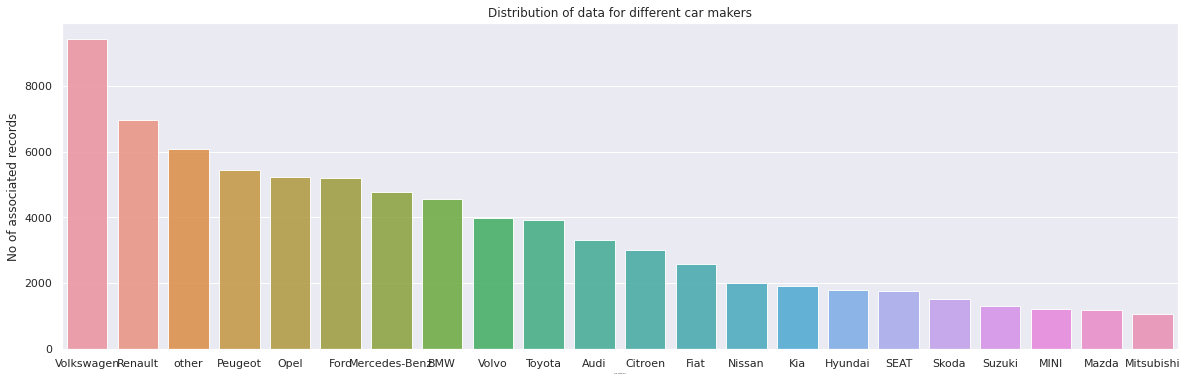

In [108]:
threshold = 1000

count_index = data['make_name'].value_counts()
data['make_name'] = np.where((count_index[data['make_name']]< threshold),"other",data.make_name)
print(len(data['make_name'].value_counts()))

name_count = data['make_name'].value_counts()
sns.set(style="darkgrid")
sns.barplot(name_count.index, name_count.values, alpha=0.9)
plt.title('Distribution of data for different car makers')
plt.ylabel('No of associated records', fontsize=12)
plt.xlabel('Car makers', fontsize=2)
plt.rcParams['figure.figsize'] = (20,6)
plt.show()


Distribution of different classes of product_tier for each category of the make_name

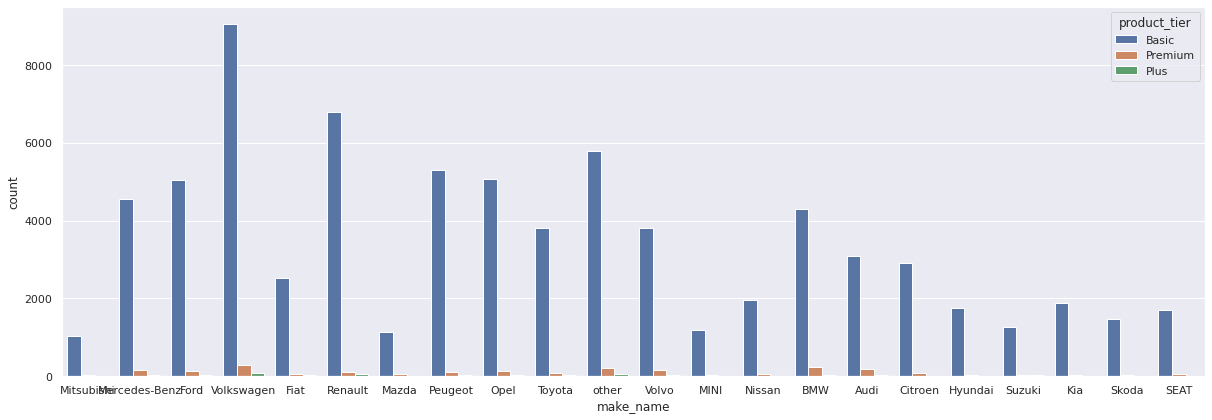

In [14]:
dims = (17,6)
fig, ax = plt.subplots(figsize=dims)
sns.countplot(x='make_name', hue="product_tier", data=data)
plt.tight_layout()

Creating a copy of cleaned and preprocessed data for second problem.

In [15]:
data_regression = data.copy()

# **Problem 1 : predict the product tier from the information given in the other columns.**

Product tier has discrete values and hence it is a case of the multiclass classification problem.

# **2. Exploratory data analysis**


Univariate analysis of numerical data


Pair plot:

Below pair plot is generated to identify correlation between different numeric variables and to identify data distribution of individual variable. 

No other variables other than search_views and detail_views are strongly correlated. Also, data seems highly imbalanced between three classes of product_tier. Furthermore, data distribution for each variable is highly skewed as well. 

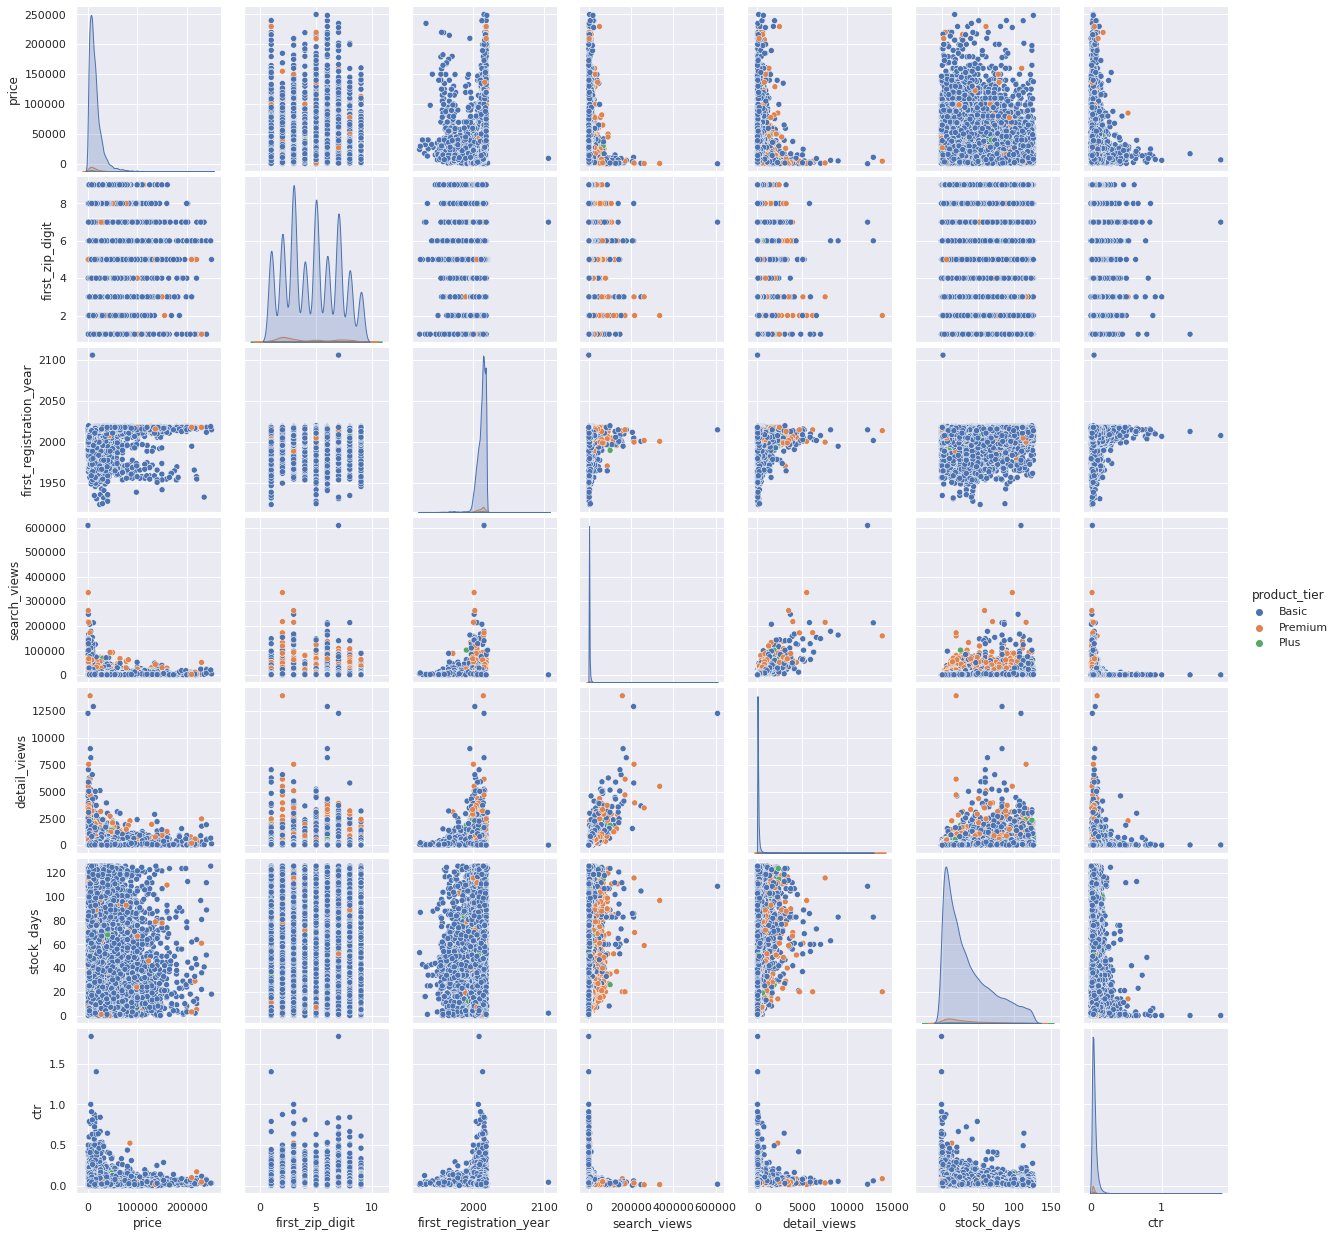

In [16]:
sns.pairplot(data,hue='product_tier')

Data distribution of the target variable

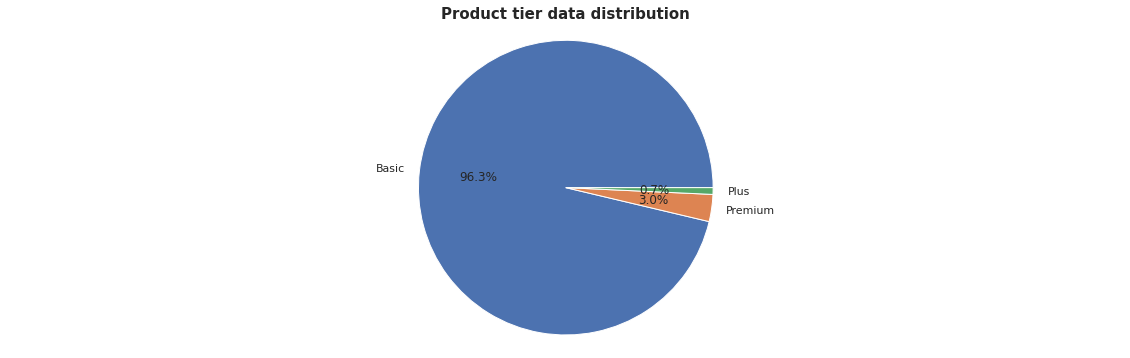

In [17]:
target = data['product_tier'].value_counts()
target.tolist()
target_vals = ['Basic', 'Premium', 'Plus']
piechart = plt.pie(target,  labels = target_vals, autopct = '%1.1f%%')
plt.title('Product tier data distribution', fontsize = 15, fontweight = 'bold')
plt.axis('equal')
plt.show()

Corrleation matrix can also be plotted to see exact correlation. Here, also it is clear that product_views and search_views are highly positively correlated(0.84). Other than that, all other variables are very weakly positively or negatively correlated.
1. 

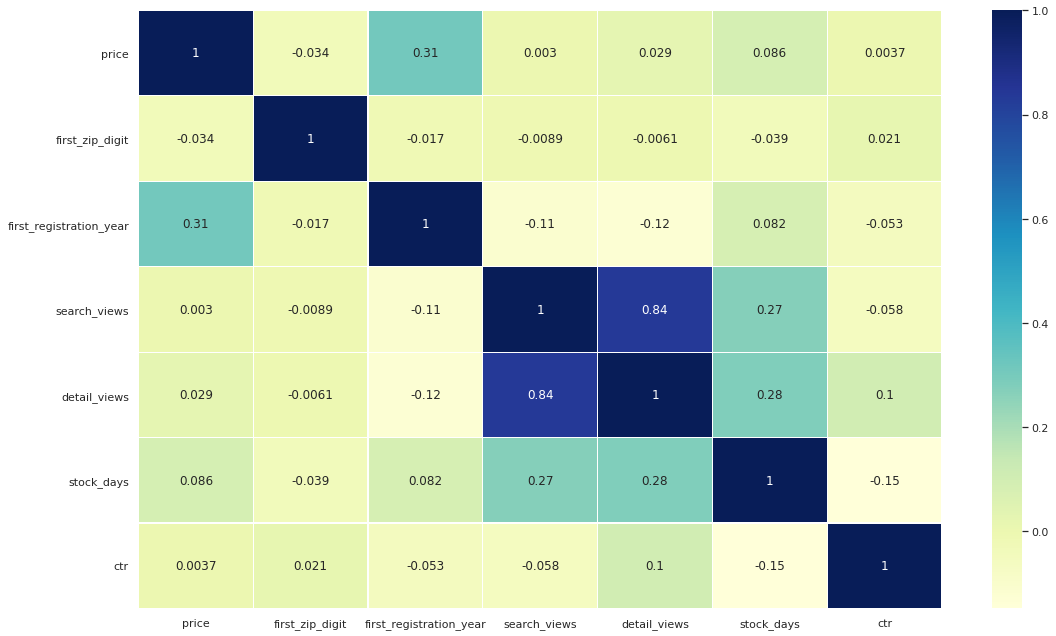

In [18]:
f,ax = plt.subplots(figsize=(18, 11))
sns.heatmap(data.corr(),cmap = "YlGnBu",annot=True, linewidths=.1,ax=ax)

In [19]:
oe1_style = OrdinalEncoder()
def vif_scores(df):
    df = df.astype('float64')

    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores
df1 = data.iloc[:,1:]
df1['make_name'] = oe1_style.fit_transform(df1[["make_name"]])# split into input and output elements
vif_scores(df1)

,Independent Features,VIF Scores
0,make_name,3.986619
1,price,1.869396
2,first_zip_digit,4.885357
3,first_registration_year,12.077797
4,search_views,4.035985
5,detail_views,4.287830
6,stock_days,2.552801
7,ctr,2.752860


# **3. Feature Generation & selection**

All features were tested for three different transformation: sqrt, logarithmic, inverse transformation
first_zip_digit, price, first_registration_year didn't yield improveness in skewness with any of the transformation.

**Log transformation of search views**

skewness for search views before correction:  24.273465495860332
skewness for search views after correction:  -0.1155164119917811


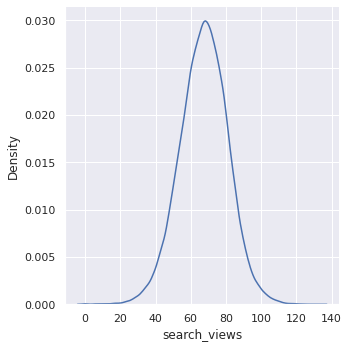

In [20]:
print("skewness for search views before correction: ",data['search_views'].skew())
data['search_views'] = np.log((1+ data['search_views']))
data['search_views'] = np.array(np.floor(np.array(data['search_views']*100) / 10.))

print("skewness for search views after correction: ",data['search_views'].skew())
sns.displot(data['search_views'],kind='kde')

**Log transfomration for detail views**

skewness for detail views:  -0.10266901103979392


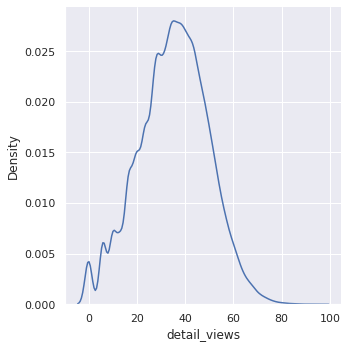

In [21]:
data['detail_views'] = np.log((1+ data['detail_views']))
data['detail_views'] = np.array(np.floor(np.array(data['detail_views']*100) / 10.))

print("skewness for detail views: ",data['detail_views'].skew())
sns.displot(data['detail_views'], kind="kde")

**Sqrt transformation for ctr**

skewness for ctr:  0.9079148511031375


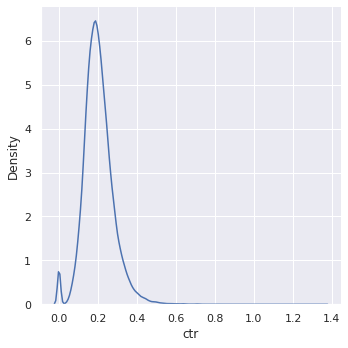

In [22]:
data['ctr'] = data['ctr']**(0.5)
print("skewness for ctr: ",data['ctr'].skew())
sns.displot(data['ctr'], kind="kde")

make_name is a nominal categorical variable so one-hot encoding is preferred. However, ordinal encoding and one hot encoding yields the same results so ordinal encoding has been used.


In [23]:
oe_style = OrdinalEncoder()
le_style = LabelEncoder()

data["make_name"] = oe_style.fit_transform(data[["make_name"]])


In [24]:
data.head(10)

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr
0,Basic,10.0,16750,5,2013,80.0,48.0,31,0.199482
1,Basic,9.0,35950,4,2015,80.0,54.0,52,0.260626
2,Basic,9.0,11950,3,1998,80.0,55.0,51,0.285681
3,Basic,4.0,1750,6,2003,75.0,32.0,101,0.118358
4,Basic,9.0,26500,3,2014,61.0,30.0,11,0.202031
5,Basic,19.0,24890,6,2017,48.0,19.0,2,0.219089
6,Basic,3.0,2850,7,2008,51.0,16.0,1,0.152499
7,Basic,14.0,23740,2,2018,73.0,46.0,87,0.256990
8,Basic,14.0,7850,6,2016,83.0,48.0,75,0.175280
9,Basic,8.0,13950,3,2016,77.0,44.0,32,0.198577


# **4. Handling data imbalance**

As we have seen that data is highly imbalanced.
Over sampling: increases the number of classes which is less in number by considering data points closer to the origical class
Under sampling: Reduces the number of classes having a high number of data points.

Over sampling puts more weight to the small class and makes the model bias to it. Where as under sampling can result in a loss of inforamtion. 

So here, my approach is combine **random oversampling and undersampling** and this can result in overall improved performance compare to performing only either of the technique.

In [25]:
y = le_style.fit_transform(data[["product_tier"]]).ravel()
y = y.ravel()
X = data.iloc[:,1:]
X_over, y_over = RandomOverSampler().fit_resample(X, y)
X_combined_sampling, y_combined_sampling = RandomUnderSampler().fit_resample(X_over, y_over)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_sampling, y_combined_sampling, train_size=0.8, random_state = 0)

# **5. Feature selection based on feature importance**

chi2 test is performed to get feature weights and then feature importance method from the random forest classification is used.In random forest, features are randomly chosen at each iteration.

From the below point, we can say that make_name and first_zip_digit are least importance features but they still have some importance so none of the feature are removed. 


In [27]:
select_feature = SelectKBest(chi2, k=5).fit(X_train,y_train)

In [28]:
print('Score list:', select_feature.scores_)
print('Feature list:', X.columns)

Score list: [6.17263548e+03 1.27944102e+07 2.18855957e+03 3.72102501e+01
 1.73842121e+05 2.44987982e+05 2.32147824e+04 6.73656036e+01]
Feature list: Index(['make_name', 'price', 'first_zip_digit', 'first_registration_year',
       'search_views', 'detail_views', 'stock_days', 'ctr'],
      dtype='object')


1. feature 4 (0.190712)
2. feature 6 (0.190384)
3. feature 7 (0.158520)
4. feature 1 (0.131121)
5. feature 5 (0.120807)
6. feature 3 (0.079499)
7. feature 0 (0.070654)
8. feature 2 (0.058304)


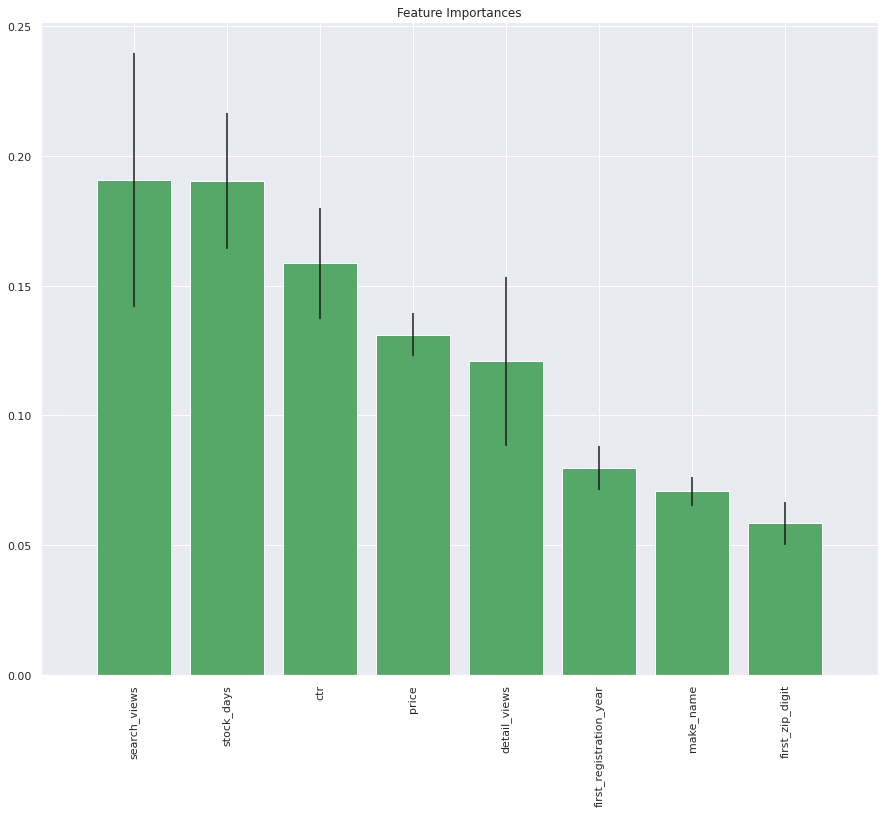

In [29]:
rcf = RandomForestClassifier()      
rcf = rcf.fit(X,y)
importances = rcf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rcf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(15, 12))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# **6. Model implementation**

Preparing data for model implementation

In [30]:
y = le_style.fit_transform(data[["product_tier"]]).ravel()
y = y.ravel()
X = data.iloc[:,1:]
X_over, y_over = RandomOverSampler().fit_resample(X, y)
X_combined_sampling, y_combined_sampling = RandomUnderSampler().fit_resample(X_over, y_over)

print(y)

[0 0 0 ... 0 0 0]


Train test splitting

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_sampling, y_combined_sampling, train_size=0.8, random_state = 0)

One-vs-rest is a heuristic method for using binary classification algorithms for multi-class classification which splits the multi-class dataset into multuple binary classification problems. A binary classifier is then trained on each binary classification problem and predictions are made using the model that is the most confident.

*   Binary Classification Problem 1: Basic vs [Premium, Plus]
*   Binary Classification Problem 2: Premium vs [Basic, Plus]
*   Binary Classification Problem 3: Plus vs [Basic, Premium]

tree based classifier such as XGBoost works well with **multiclass imbalanced data** hence, I decided to use XGBoost classifier with one-vs-rest parameter for ROC AUC score.



In [42]:
start_xgb = time.time()

xgb = XGBClassifier(use_label_encoder=False)
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring='accuracy')
print('The accuracy of the XGB classifier with 10 fold cross-validation is ' + str(xgb_scores.mean()))

end_xgb =time.time()
xgb_time = (end_xgb-start_xgb) / 60
print('The time taken for the XGB classifier for 10 fold cross validation is ' + str(xgb_time))

The accuracy of the XGB classifier with 10 fold cross-validation is 0.7777777741142787
The time taken for the XGB classifier for 10 fold cross validation is 2.6990821321805316


In [43]:
xgb_cv_mean = np.mean(xgb_scores)
xgb_cv_variance = np.var(xgb_scores)

print('XGB Mean score : ', xgb_cv_mean)
print('XGB Score variance : ', xgb_cv_variance)

XGB Mean score :  0.7777777741142787
XGB Score variance :  9.32621860933046e-06


For cost-sensitive learning, sample_weight parameter in fit is used sample_weight parameter allows to specify a different weight for each training example.

In [44]:
xgb.fit(X_train, y_train,sample_weight=compute_sample_weight("balanced",y_train)) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [45]:
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

In [46]:

def print_results(y_test,y_pred,y_pred_proba):
  from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,log_loss,roc_auc_score
  x = PrettyTable()
  x.field_names = ["Evaluation Metric", "Score"]
  x.add_row(['Accuracy',accuracy_score(y_test, y_pred)])
  x.add_row(['F1 score macro',f1_score(y_test, y_pred, average='macro')])
  x.add_row(['F1 score micro',f1_score(y_test, y_pred, average='micro')])
  x.add_row(['Precision score macro',precision_score(y_test, y_pred, average='macro')])
  x.add_row(['Recall score macro',recall_score(y_test, y_pred, average='macro')])
  x.add_row(['Log loss',log_loss(y_test, y_pred_proba)])
  x.add_row(['AUC & ROC',roc_auc_score(y_test,y_pred_proba,multi_class="ovr")])
  print(x)

  print("classification_report")
  labels=[0,1,2]
  cm = confusion_matrix(y_test,y_pred, labels)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax,cmap='Greens',fmt='g'); #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['Basic', 'Premium','Plus']); ax.yaxis.set_ticklabels(['Basic', 'Premium','Plus']);

+-----------------------+--------------------+
|   Evaluation Metric   |       Score        |
+-----------------------+--------------------+
|        Accuracy       | 0.7740794766388189 |
|     F1 score macro    | 0.7739342969172291 |
|     F1 score micro    | 0.7740794766388189 |
| Precision score macro | 0.7744936557724755 |
|   Recall score macro  | 0.7741201257281167 |
|        Log loss       | 0.5871730249243643 |
|       AUC & ROC       | 0.917262652931957  |
+-----------------------+--------------------+
classification_report


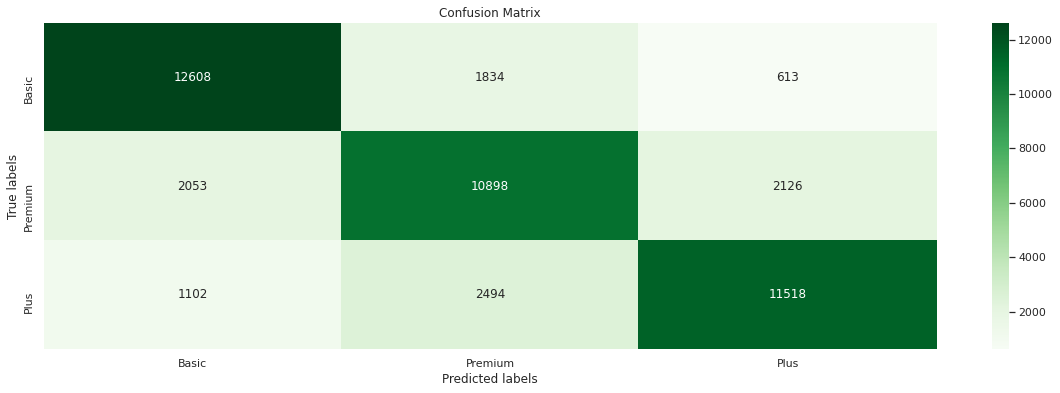

In [47]:
print_results(y_test,y_pred,y_pred_proba)

# **6. Tuning for gboost classifier:**

Model tuning is performed using Grid Search method. Below four parameters are tuned :


*   max_depth: It is the maximum depth of a tree 
*   min_child_weight: It is the minimum sum of weights of all observations required in a child
*   subsample: It is the the fraction of observations to be randomly samples for each tree
*   colsample_bytree: It is the the fraction of columns to be randomly samples for each tree



In [48]:
xgb_model = XGBClassifier()

params = {
   # Parameters that we are going to tune.
    'max_depth':['4', '5', '6'],
    'min_child_weight':['1','3','5'],
    'subsample':['0.8','0.9','1.0'],
    'colsample_bytree': ['0.5','0.7','0.8'],
    }

search = GridSearchCV(xgb_model, param_grid=params, cv=3, verbose=1, n_jobs=1, return_train_score=True)
search.fit(X_train, y_train)
search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 79.0min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree='0.5', gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth='6',
              min_child_weight='3', missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample='0.9', verbosity=1)

In [50]:
start_xgb = time.time()

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree='0.5', gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth='6',
              min_child_weight='3', missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softmax', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample='0.9', verbosity=1)

xgb_scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring='accuracy')
print('The accuracy of the XGB classifier with 10 fold cross-validation is ' + str(xgb_scores.mean()))

end_xgb =time.time()
xgb_time = (end_xgb-start_xgb)
print('The time taken for the classifier for 10 fold cross validation is ' + str(xgb_time))

The accuracy of the XGB classifier with 10 fold cross-validation is 0.9208259058179973
The time taken for the classifier for 10 fold cross validation is 258.40840125083923


In [51]:
xgb_cv_mean = np.mean(gb_scores)
xgb_cv_variance = np.var(gb_scores)

print('gb Mean score : ', gb_cv_mean)
print('gb Score variance : ', gb_cv_variance)

gb Mean score :  0.7983489986689349
gb Score variance :  6.581695501383418e-06


In [52]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree='0.5', gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth='6',
              min_child_weight='3', missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample='0.9', verbosity=1)

In [53]:
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

+-----------------------+---------------------+
|   Evaluation Metric   |        Score        |
+-----------------------+---------------------+
|        Accuracy       |  0.9256508862661893 |
|     F1 score macro    |  0.9253401699265664 |
|     F1 score micro    |  0.9256508862661893 |
| Precision score macro |  0.9268570195923725 |
|   Recall score macro  |  0.9256458768159092 |
|        Log loss       | 0.34315153570128004 |
|       AUC & ROC       |  0.9839893073782555 |
+-----------------------+---------------------+
classification_report


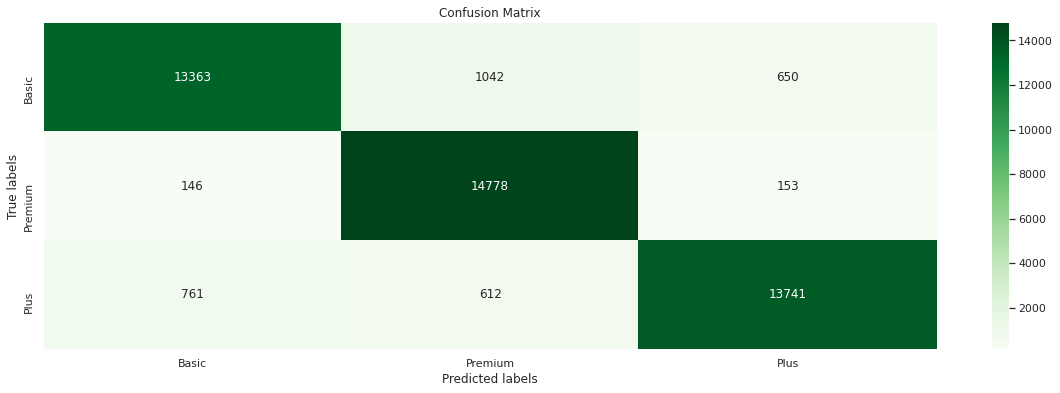

In [54]:
print_results(y_test,y_pred,y_pred_proba)

# **Reflection on results:**
Cross validation training accuracy of the Model and testing accuracy are almost similar, which shows that the model is not overfitting on the training data. Also, much improvement in performance is seen in accuracy after hypertuning of the parameters. 

Also, this is a case of the multiclass classification with highly imbalance dataset and the target class 'Basic' is 96.3% of total data so even if the model predicts the 'Basic' class all the time, it gives the accuracy of 96.3% by ignoring other two classes. So accuracy doesn't seem to be a good choice as an evaluation metric.

So here, I have done combined random oversampling and undersampling to deal with imbalanced data and focus on log loss and ROC & AUC score for evaluation. Here, log loss(0.34) has reduced after hyper tuning and ROC & AUC score has increased(0.98) so it can be concluded that model is performing well on all three classes of target variable.

# **Problem 2 : Predict detail views from the information given in the other columns.** 

Detail views is continuous(numerical) variable and there are more than two dependent variable so it is a **multiple linear regression** problem.

In [55]:
data_regression.head(5)

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr
0,Basic,Mitsubishi,16750,5,2013,3091.0,123.0,31,0.039793
1,Basic,Mercedes-Benz,35950,4,2015,3283.0,223.0,52,0.067926
2,Basic,Mercedes-Benz,11950,3,1998,3247.0,265.0,51,0.081614
3,Basic,Ford,1750,6,2003,1856.0,26.0,101,0.014009
4,Basic,Mercedes-Benz,26500,3,2014,490.0,20.0,11,0.040816


# **Target variable distribution:**

One of the assumption of multiple linear regression is, that to create any linear model, features have to be normally distributed. Below is the histogram,Q-Q plot and box plot of the target variable. 

Based on charts, it is clear that view_details is not normally distributed and it is right skewed. And also there are significant number of outliers.

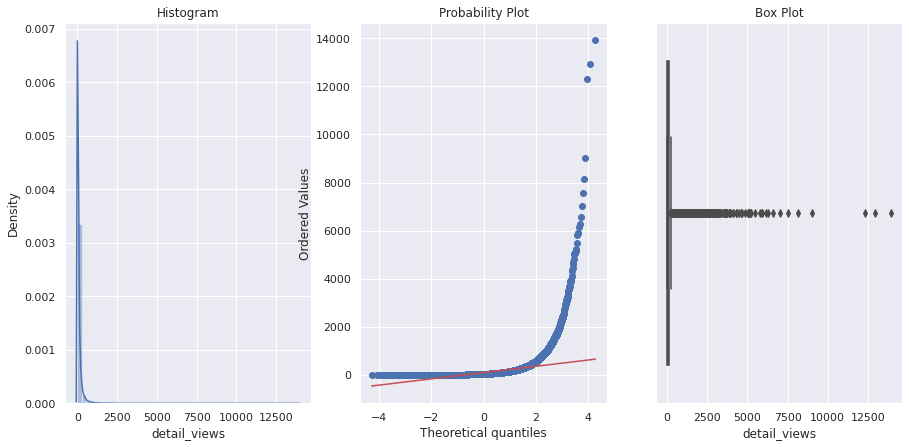

In [56]:
def plotting_target(data,target): 
    
    fig, ax = plt.subplots(figsize=(15,7), ncols=3, nrows=1)
   
    ax[0].set_title('Histogram')  ## Set the title.    
    sns.distplot(data.loc[:,target], norm_hist=True, ax = ax[0]) ## plot the histogram. 
    
    ax[1].set_title('QQ_plot') ## Set the title.     
    stats.probplot(data.loc[:,target], plot = ax[1]) ## Plotting the QQ_Plot.

    ax[2].set_title('Box Plot') ## Set title. 
    sns.boxplot(data.loc[:,target], ax = ax[2]);  ## Plotting the box plot. 

target = 'detail_views'  
plotting_target(data_regression,target)

# **Scatter plot of target variable vs predictor variables**

Target variable detail_views shows unequal level of variance across almost all predictor variables and there is an indication of large number of outliers as well. 

detail_views and search_views seems to have a positive correlation. That is, as the number of search_views increases, detail_views increase as well. Also it is understandable that as the number of times articles appear in search results, chances of articles being clicked increase as well.

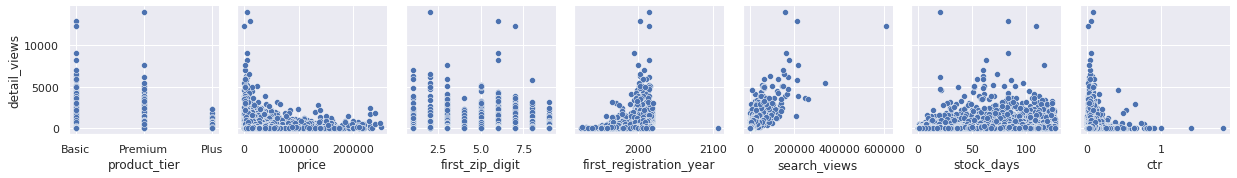

In [57]:
def plot_pairplot_with_target(data,target,drop_columns):
  
  data_plot = data.copy()
  data_plot = data_plot.drop(drop_columns,axis=1)
  sns.pairplot(data, y_vars=target, x_vars=data_plot.columns.values)

target = 'detail_views'
drop_columns = ['make_name','detail_views']
plot_pairplot_with_target(data_regression,target,drop_columns)

Also we can check the linear relationship in more depth by below scatter plot of search_views and detail_views.

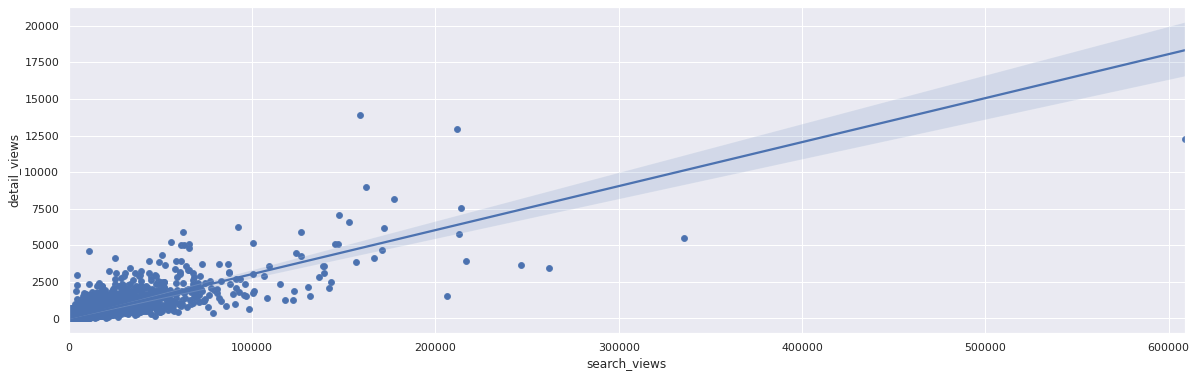

In [58]:
def plot_scatterplot(targetVar,independentVar):
  sns.scatterplot( x = independentVar , y = targetVar)
  sns.regplot(x = independentVar , y = targetVar)   ## Putting a regression line. 

targetVar = data_regression.detail_views
independentVar = data_regression.search_views
plot_scatterplot(targetVar,independentVar)

# **No or little multicolinearity**:

Multicolinearity is a strong correlation between predictor variables. Multilinear regression requires little or no multicolinearity between predictor variables. We can plot correlation matrix to check multicolinearity and it shows that there is not any strong positive or negative correlation between any of the independent variable pairs.

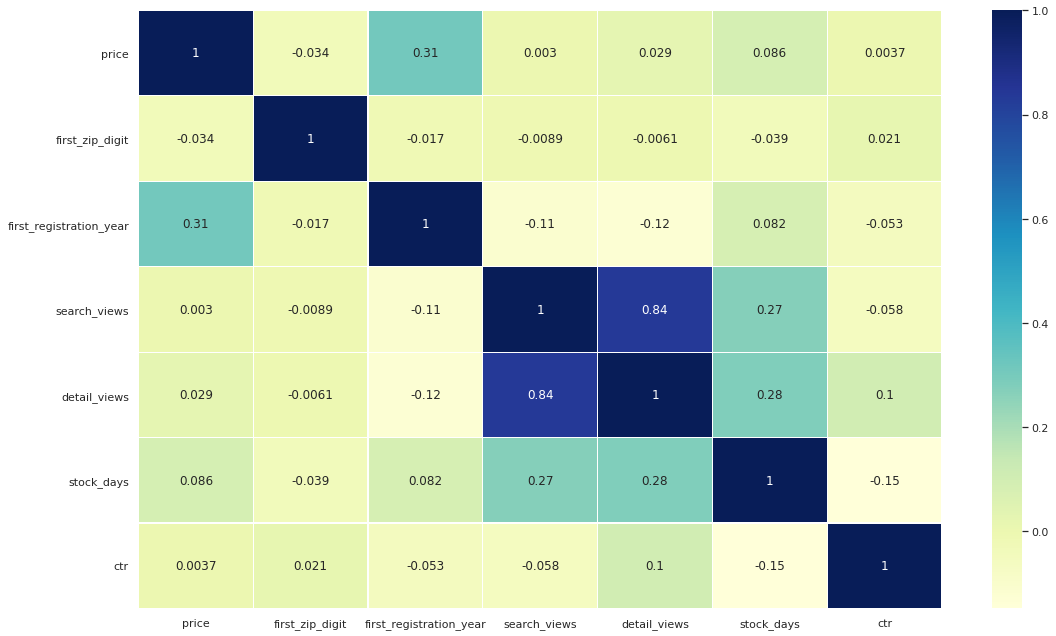

In [59]:
f,ax = plt.subplots(figsize=(18, 11))
sns.heatmap(data_regression.corr(), cmap = "YlGnBu",annot=True, linewidths=.1,ax=ax)

The linear regression analysis needs the target variable to be normally distributed. Detail_views is not following normal distribution so we can apply log transformation on detail_views and again plot histogram, Q-Q plot and box plot. 

After log transformation, detail_views distribution seems closer to normal distribution along with decrease in number of outliers.

In [60]:
data_regression['detail_views_updated'] = np.log((1+ data_regression['detail_views']))
data_regression['detail_views_updated'] = np.array(np.floor(np.array(data_regression['detail_views_updated']*100) / 10.))

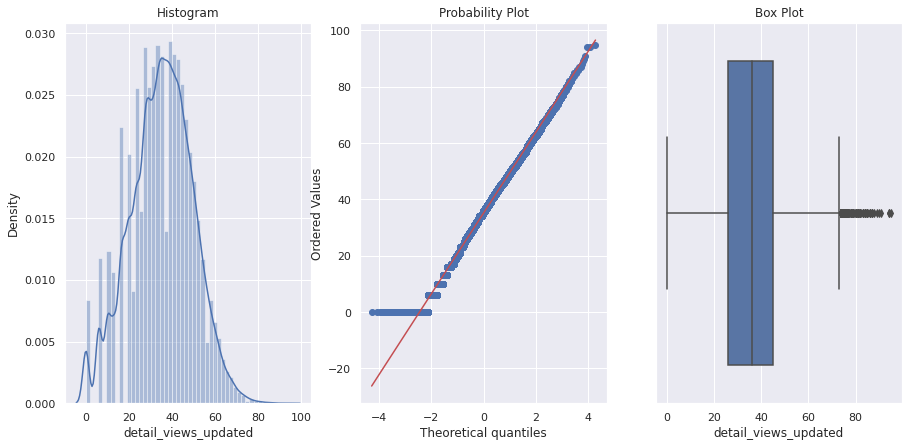

In [61]:
target = 'detail_views_updated'  
plotting_target(data_regression,target)

Also here plotting the scatter plot of target variable and predictor variables to see the change in relationship between them after log transformation of target variable. 

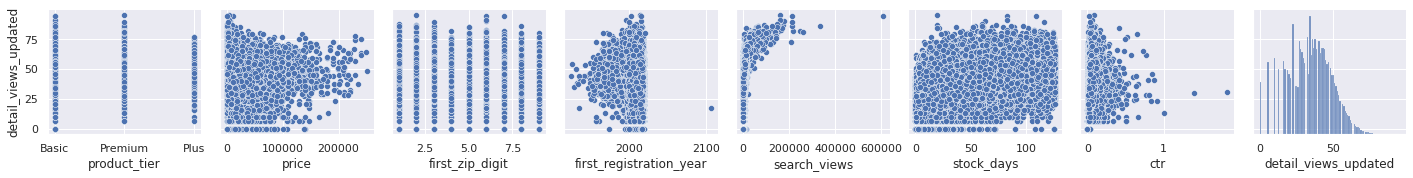

In [62]:
target = 'detail_views_updated'
drop_columns = ['make_name','detail_views']
plot_pairplot_with_target(data_regression,target,drop_columns)

# **Detecting outliers :**

Interquartile range or midspread helps to detect outliers using first and third quartile. Below we can see that after log transfomration, no outliers are found which also confirms that log transfomration is a good choice for target variable.

In [63]:
Q1 = data_regression['detail_views_updated'].quantile(0.25)
Q3 = data_regression['detail_views_updated'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (data_regression['detail_views_updated'] >= Q1 - 1.5 * IQR) & (data_regression['detail_views_updated'] <= Q3 + 1.5 *IQR)
data_filter = data_regression.copy()
data_filter.loc[filter] 

print("Found outliers: ",data_regression.shape[0] - data_filter.shape[0])


Found outliers:  0


Encoding of categorical data

In [64]:
oe_style = OrdinalEncoder()
le_style = LabelEncoder()

data_regression["make_name"] = oe_style.fit_transform(data_regression[["make_name"]])
data_regression["product_tier"] = oe_style.fit_transform(data_regression[["product_tier"]])
data_regression['detail_views'] = data_regression['detail_views_updated']
data_regression.drop(['detail_views_updated'],axis=1, inplace=True)

In [65]:
data_regression.head(10)


,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr
0,0.0,10.0,16750,5,2013,3091.0,48.0,31,0.039793
1,0.0,9.0,35950,4,2015,3283.0,54.0,52,0.067926
2,0.0,9.0,11950,3,1998,3247.0,55.0,51,0.081614
3,0.0,4.0,1750,6,2003,1856.0,32.0,101,0.014009
4,0.0,9.0,26500,3,2014,490.0,30.0,11,0.040816
5,0.0,19.0,24890,6,2017,125.0,19.0,2,0.048000
6,0.0,3.0,2850,7,2008,172.0,16.0,1,0.023256
7,0.0,14.0,23740,2,2018,1499.0,46.0,87,0.066044
8,0.0,14.0,7850,6,2016,4329.0,48.0,75,0.030723
9,0.0,8.0,13950,3,2016,2257.0,44.0,32,0.039433


# **Data preparation for Regression**

In [66]:
columns = ['detail_views']
y = data_regression.detail_views
X = data_regression.drop(columns, axis=1)


In [67]:
# Split X and y into train and test sets: 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [68]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(62647, 8) (15662, 8) (62647,) (15662,)


In [69]:
train_mean = X_train.mean()
train_std = X_train.std() 

In [70]:
#Standardize the train data set
X_train = (X_train - train_mean) / train_std

In [71]:
## Check for mean and std dev.
X_train.describe()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,stock_days,ctr
count,6.264700e+04,6.264700e+04,6.264700e+04,6.264700e+04,6.264700e+04,6.264700e+04,6.264700e+04,6.264700e+04
mean,-1.018486e-16,-1.735646e-16,-4.991458e-17,9.668565e-16,-7.895978e-16,-2.430424e-17,-1.055205e-16,4.240805e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.906567e-01,-1.731593e+00,-9.185236e-01,-1.542705e+00,-1.329193e+01,-3.565619e-01,-1.114356e+00,-1.206017e+00
25%,-1.906567e-01,-9.915323e-01,-5.678112e-01,-6.928696e-01,-4.697641e-01,-2.995924e-01,-8.041955e-01,-5.824335e-01
50%,-1.906567e-01,1.925643e-01,-2.536403e-01,1.569660e-01,2.934600e-01,-2.136712e-01,-3.389544e-01,-2.220307e-01
75%,-1.906567e-01,9.326247e-01,2.343922e-01,1.006802e+00,5.987496e-01,-1.054229e-02,5.915279e-01,3.060965e-01
max,5.554447e+00,1.376661e+00,1.423123e+01,1.856637e+00,1.448943e+01,9.439865e+01,2.793669e+00,4.607822e+01


In [72]:
## Note: We use train_mean and train_std_dev to standardize test data set
X_test = (X_test - train_mean) / train_std

In [73]:
X_test.describe()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,stock_days,ctr
count,15662.000000,15662.000000,15662.000000,15662.000000,15662.000000,15662.000000,15662.000000,15662.000000
mean,0.004857,-0.015014,0.003463,0.002783,0.009300,0.005361,0.009611,0.017250
std,1.008787,1.001992,0.994813,1.002078,0.990295,0.931659,0.995798,1.005162
min,-0.190657,-1.731593,-0.915534,-1.542705,-13.139284,-0.356562,-1.114356,-1.206017
25%,-0.190657,-0.991532,-0.562016,-0.692870,-0.469764,-0.298192,-0.804195,-0.570478
50%,-0.190657,0.192564,-0.251200,0.156966,0.293460,-0.211648,-0.307938,-0.211541
75%,-0.190657,0.932625,0.225242,1.006802,0.598750,-0.002604,0.591528,0.311903
max,5.554447,1.376661,14.325599,1.856637,1.361974,32.970749,2.793669,22.240711


In [74]:
# Functions to display results
def show_results(classifier,y_train,y_train_pred,y_test,y_pred): 

  x = PrettyTable()
  x.field_names = ["Classifier", "Train RMSE", "Train MAE", "Test RMSE", "Test MAE"]
  x.add_row([classifier,sqrt(mse(y_train.values, y_train_pred)),mae(y_train.values, y_train_pred),sqrt(mse(y_test, y_pred)),mae(y_test, y_pred)])

  print(x)

# **Baseline Model**

In [75]:
## Baseline model to compare regression model results
y_train_pred = np.ones(y_train.shape[0])*y_train.mean()
y_pred = np.ones(y_test.shape[0])*y_train.mean()

In [76]:
show_results("Base line Model",y_train,y_train_pred,y_test,y_pred)

+-----------------+--------------------+--------------------+-------------------+--------------------+
|    Classifier   |     Train RMSE     |     Train MAE      |     Test RMSE     |      Test MAE      |
+-----------------+--------------------+--------------------+-------------------+--------------------+
| Base line Model | 14.325219976952692 | 11.455605339573646 | 14.38903833147189 | 11.521824291791564 |
+-----------------+--------------------+--------------------+-------------------+--------------------+


# **Linear regression model**

In [81]:
linear = LinearRegression()
linear.fit(X_train, y_train)

y_train_pred = linear.predict(X_train)
y_pred = linear.predict(X_test)

show_results("Linear regression",y_train,y_train_pred,y_test,y_pred)

+-------------------+-------------------+--------------------+-------------------+-------------------+
|     Classifier    |     Train RMSE    |     Train MAE      |     Test RMSE     |      Test MAE     |
+-------------------+-------------------+--------------------+-------------------+-------------------+
| Linear regression | 9.745436124919399 | 7.5187651864433755 | 9.637191703422449 | 7.519706692515694 |
+-------------------+-------------------+--------------------+-------------------+-------------------+


# **Ridge regression model**

In [83]:
ridge = Ridge()
ridge.fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

show_results("Ridge regression",y_train,y_train_pred,y_test,y_pred)

+------------------+-------------------+-------------------+-------------------+-------------------+
|    Classifier    |     Train RMSE    |     Train MAE     |     Test RMSE     |      Test MAE     |
+------------------+-------------------+-------------------+-------------------+-------------------+
| Ridge regression | 9.745436126323376 | 7.518778383691442 | 9.637193099763975 | 7.519721183707504 |
+------------------+-------------------+-------------------+-------------------+-------------------+


# **Support vector regression:**

In [94]:
svr = SVR()
svr.fit(X_train, y_train)

## Predict Train results
y_train_pred = svr.predict(X_train)

## Predict Test results
y_pred = svr.predict(X_test)

show_results("Support vector regression",y_train,y_train_pred,y_test,y_pred)

+---------------------------+-------------------+-------------------+------------------+-------------------+
|         Classifier        |     Train RMSE    |     Train MAE     |    Test RMSE     |      Test MAE     |
+---------------------------+-------------------+-------------------+------------------+-------------------+
| Support vector regression | 4.204867397680715 | 2.732112998287344 | 4.20981145118082 | 2.747154795697386 |
+---------------------------+-------------------+-------------------+------------------+-------------------+


# **Random forest regression**

In [86]:
randomforest = RandomForestRegressor()
randomforest.fit(X_train, y_train)

## Predict Train results
y_train_pred = randomforest.predict(X_train)

## Predict Test results
y_pred = randomforest.predict(X_test)

show_results("Random forest regressor",y_train,y_train_pred,y_test,y_pred)

+-------------------------+---------------------+---------------------+---------------------+---------------------+
|        Classifier       |      Train RMSE     |      Train MAE      |      Test RMSE      |       Test MAE      |
+-------------------------+---------------------+---------------------+---------------------+---------------------+
| Random forest regressor | 0.10861782679852368 | 0.04985649751783813 | 0.25115747883055256 | 0.13204699272123616 |
+-------------------------+---------------------+---------------------+---------------------+---------------------+


# **XGB Regression model**

In [87]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

## Predict Train results
y_train_pred = xgb.predict(X_train)

## Predict Test results
y_pred = xgb.predict(X_test)

show_results("gboost regressor",y_train,y_train_pred,y_test,y_pred)

[20:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
+------------------+--------------------+---------------------+--------------------+--------------------+
|    Classifier    |     Train RMSE     |      Train MAE      |     Test RMSE      |      Test MAE      |
+------------------+--------------------+---------------------+--------------------+--------------------+
| gboost regressor | 0.6890616858047001 | 0.49896574789622183 | 0.6794205568380497 | 0.5005453053698687 |
+------------------+--------------------+---------------------+--------------------+--------------------+


# **Lasso regressor model**

In [88]:
lasso = Lasso()
lasso.fit(X_train, y_train)

## Predict Train results
y_train_pred = lasso.predict(X_train)

## Predict Test results
y_pred = lasso.predict(X_test)

show_results("Lasso regressor",y_train,y_train_pred,y_test,y_pred)

+-----------------+--------------------+-------------------+-------------------+-------------------+
|    Classifier   |     Train RMSE     |     Train MAE     |     Test RMSE     |      Test MAE     |
+-----------------+--------------------+-------------------+-------------------+-------------------+
| Lasso regressor | 10.013336767334406 | 7.902385717032923 | 9.939981775783355 | 7.925572818124445 |
+-----------------+--------------------+-------------------+-------------------+-------------------+


# **LGBM Regressor**

In [89]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

## Predict Train results
y_train_pred = lgbm.predict(X_train)

## Predict Test results
y_pred = lgbm.predict(X_test)

show_results("LGBM regressor",y_train,y_train_pred,y_test,y_pred)

+----------------+-------------------+---------------------+-------------------+--------------------+
|   Classifier   |     Train RMSE    |      Train MAE      |     Test RMSE     |      Test MAE      |
+----------------+-------------------+---------------------+-------------------+--------------------+
| LGBM regressor | 0.504092891980069 | 0.33686342065874025 | 0.566649508147294 | 0.3548929814967622 |
+----------------+-------------------+---------------------+-------------------+--------------------+


# **Reflection on results:**

All regressor models are performing better than baseline model. From the above results, RMSE, MAE for Random Forest Regressor is better(i.e RMSE and MAE is least). However, for the test dataset, RMSE and MAE are higher than train dataset. Support vector regressor also has a lower RMSE and MAE score for train and test dataset. 

For further improving the performance, tuning of random forest regressor and suppoer vector regressor can be done. In addition, more experiments such as feature engineering can be done by removing least important features, using different encoding for categorical variables etc can be applied.